# Alternative explanations: Genetic drift and Pool-Nielsen effect

---

Variables to allow differentation of file names for analyses based on different calling criteria. Should be commented out when run in batch with `slurm-jupyter-run.py`

**NB:** comment out the cell below if you want to run using `slurm-jupyter-run.py`. Otherwise it will overwrite variables set by `slurm-jupyter-run.py`.

In [1]:
from nb_parameters import extract_parameter_code
exec(extract_parameter_code('nb_parameters.ipynb', '5e-05_25%'))

----

In [2]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import numpy as np
import pandas
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Plotting setup:

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

import random
df = DataFrame({'x': random.sample(range(1, 100), 5), 
                'y': random.sample(range(1, 100), 5),
                'z': [1,0,0,1,0],
                'k': ['male','male','male','female','female'] })

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore deprecation warnings from mainly seaborn:

In [4]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### Analysis dirs

In [5]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Local code in the scripts dir on the cluster:

In [6]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

In [7]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        self.start_real = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.end_real = time.time()
        self.interval = self.end - self.start
        self.interval_real = self.end_real - self.start_real
        print("clock: {:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))
        print("time: {:.0f} min {:.1f} sec".format(self.interval_real//60, self.interval_real % 60))

## The probability that a haplotype rise to some frequency without recombining

I use multinomial sampling to compute the number of generations until a haplotype first reaches the target frequency. In the cases where this is happens, I compute the probability that the haplotype did not recombine with other haplotypes in the meantime. Computed in `multinom_sampling.py` where parameters are also hardcoded.

In [25]:
df = pandas.read_hdf('../results/multinom_sampling.hdf').loc[lambda df: df.max_gens == 344]

df['prob_none_on_chr'] = 1 - (1 - df.prob)**(153e6 / df.length)

# upper bound on probability if it is reported as zero do to insuficcient sampling
df['limit_prob'] = (1/df.n_samples) * ( np.exp(-df.rec * df.length * df.max_gens) + (1 - np.exp(-df.rec * df.length * df.max_gens))/2 )
df['limit_prob_none_on_chr'] = 1 - (1 - df.limit_prob)**(153e6 / df.length)

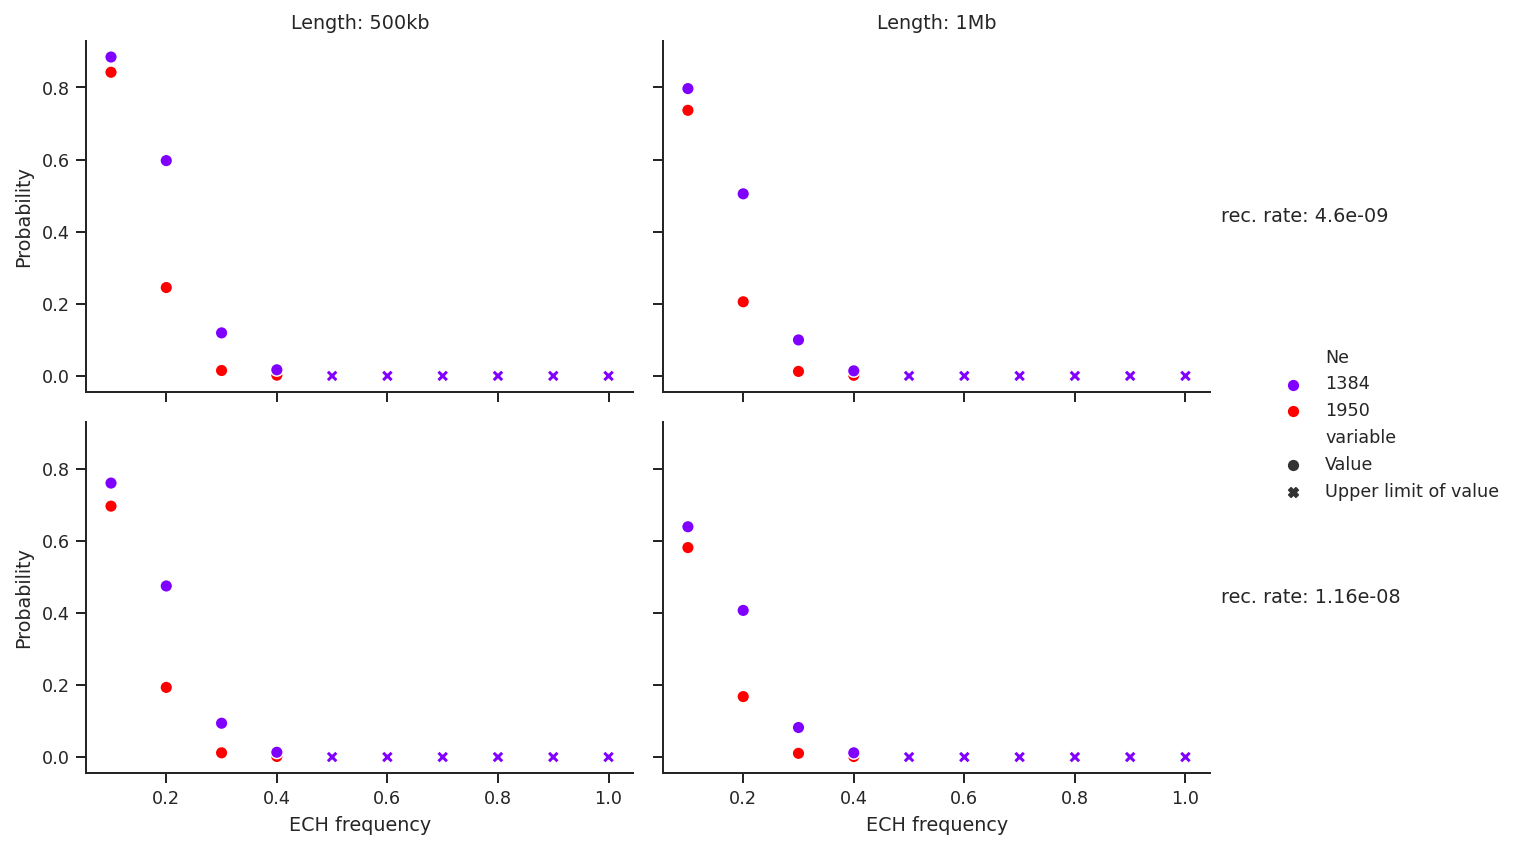

In [26]:
plot_df = df.copy()

plot_df.loc[plot_df['prob'] == 0, 'prob'] = np.nan
plot_df.loc[plot_df['prob'] > 0, 'limit_prob'] = np.nan
plot_df.rename(columns={'prob': 'Value', 'limit_prob': 'Upper limit of value'}, inplace=True)

plot_df.loc[df['length'] == 500000.0, 'length'] = '500kb'
plot_df.loc[df['length'] == 1000000.0, 'length'] = '1Mb'

plot_df = plot_df.melt(id_vars=['haploid_N', 'freq', 'rec', 'length'], value_vars=['Value', 'Upper limit of value'])
plot_df['Ne'] = (plot_df.haploid_N / 2).astype('int')

with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        with sns.color_palette("tab10"):
        
            g = sns.relplot(data=plot_df,
                            x='freq', y='value', col='length', row='rec', hue='Ne',  
                            kind='scatter', style='variable',
                              height=3, aspect=1.5,
                            palette='rainbow',
                            legend="full",                            
                            facet_kws=dict(sharex=True, sharey=True, margin_titles=True),
                            s=40
                             )
#            plt.yscale('log')
            
        for ax in g.axes.flat:
            plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
            g.set_titles(row_template = 'rec. rate: {row_name}', col_template = 'Length: {col_name}')

        for ax in g.axes.flat:
            ax.set_xlabel('ECH frequency') # need to set labels manually because the names of facet function are start and end.
            ax.set_ylabel('Probability')
            plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

            
        plt.savefig(figures_dir / 'multinom_sims.pdf', bbox_inches='tight')

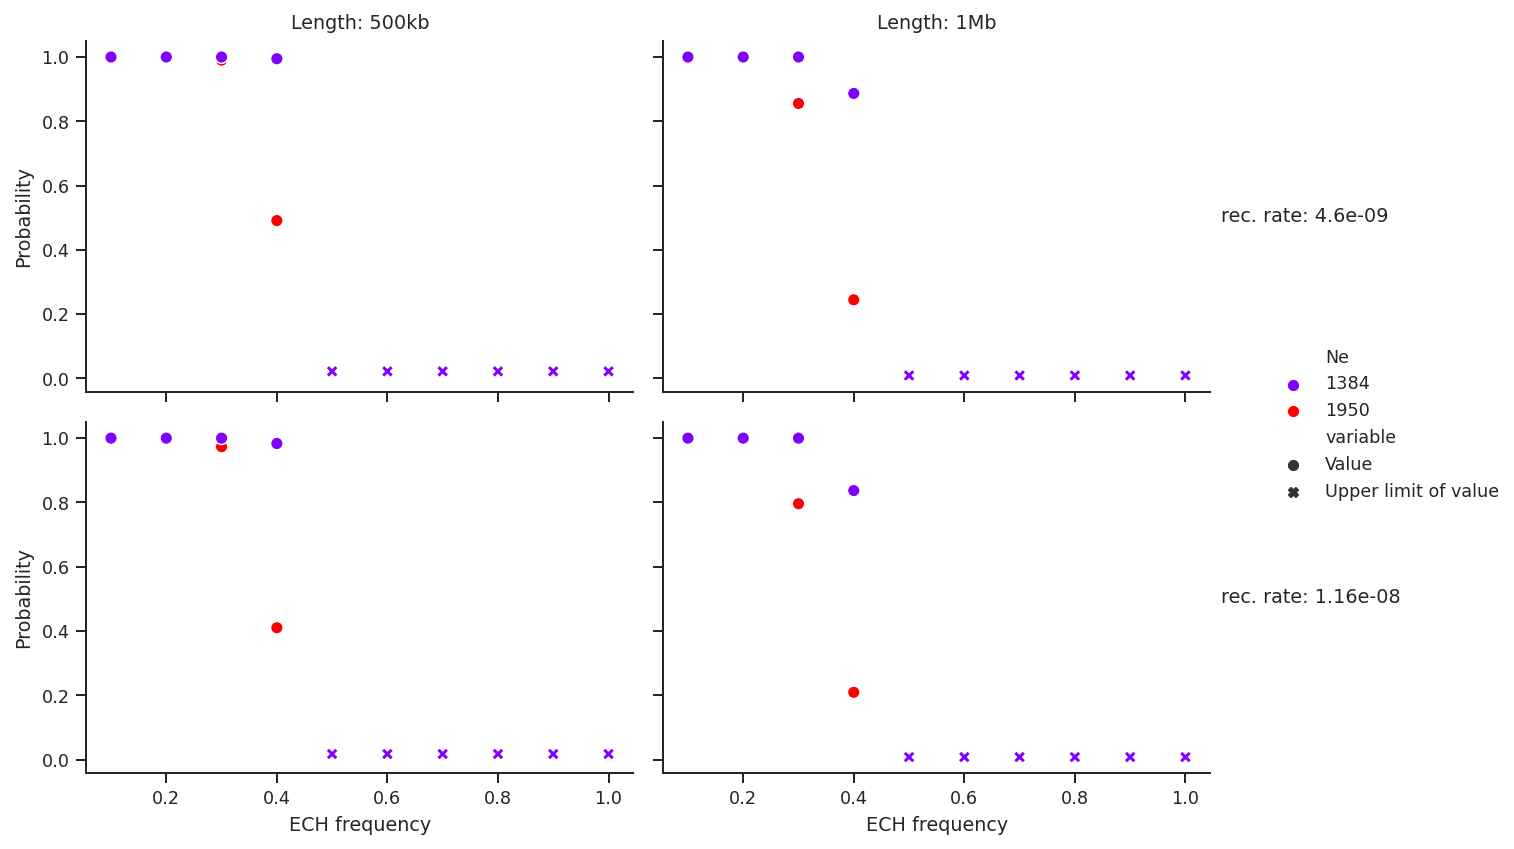

In [28]:
plot_df = df.copy()

plot_df.loc[plot_df['prob_none_on_chr'] == 0, 'prob_none_on_chr'] = np.nan
plot_df.loc[plot_df['prob_none_on_chr'] > 0, 'limit_prob_none_on_chr'] = np.nan
plot_df.rename(columns={'prob_none_on_chr': 'Value', 'limit_prob_none_on_chr': 'Upper limit of value'}, inplace=True)

plot_df.loc[df['length'] == 500000.0, 'length'] = '500kb'
plot_df.loc[df['length'] == 1000000.0, 'length'] = '1Mb'

plot_df = plot_df.melt(id_vars=['haploid_N', 'freq', 'rec', 'length'], value_vars=['Value', 'Upper limit of value'])
plot_df['Ne'] = (plot_df.haploid_N / 2).astype('int')

with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        with sns.color_palette("tab10"):
        
            g = sns.relplot(data=plot_df,
                            x='freq', y='value', col='length', row='rec', hue='Ne',  
                            kind='scatter', style='variable',
                              height=3, aspect=1.5,
                            palette='rainbow',
                            legend="full",                            
                            facet_kws=dict(sharex=True, sharey=True, margin_titles=True),
                            s=40
                             )
#            plt.yscale('log')
            
        for ax in g.axes.flat:
            plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
            g.set_titles(row_template = 'rec. rate: {row_name}', col_template = 'Length: {col_name}')

        for ax in g.axes.flat:
            ax.set_xlabel('ECH frequency') # need to set labels manually because the names of facet function are start and end.
            ax.set_ylabel('Probability')
            plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

            
        plt.savefig(figures_dir / 'multinom_sims.pdf', bbox_inches='tight')

In [16]:
# g = sns.catplot(y="tot_reached", col="freq", row="haploid_N",
#                 data=df,
#                 kind="box", height=2.5, aspect=.8)

In [10]:
# np.random.seed(7)

# import itertools
# from collections import defaultdict
# from math import exp

# # african X/A ratio is 0.65 but is further reduced inside regions (lower african X pi in regions):
# nonafr_x_auto_ratios = [0.65 * x for x in [1, 0.71]] # outside and inside regions

# # mean per generation recombination rate in regions (new decode map):
# sexavg_rec_rates_per_gen = [0.46e-8, # mean in regions
#                             1.16e-8] # global for chrX
# autosomal_bottle_N = 3000
# generations = int(10000 / 29)

# # parameters for computation
# haploid_N = [int(2 * autosomal_bottle_N * x) for x in nonafr_x_auto_ratios]
# target_freqs = np.linspace(0.1, 1, 10)
# g = [generations, generations*2]
# r = sexavg_rec_rates_per_gen
# L = [5e5, 1e6]
# n_samples = 10
# parameters = list(itertools.product(haploid_N, target_freqs, g, r, L))

In [11]:
# #simulated_trajectories = defaultdict(list)
# gens_freq_reached = {}
# for i in range(n_samples):
#     for N in haploid_N:
#         if N not in gens_freq_reached: 
#             gens_freq_reached[N] = defaultdict(list)
#         trajectory = []
#         counts = np.array(np.ones(N))
#         trajectory.append(counts)
#         while np.count_nonzero(counts) > 1:
#             counts = np.random.multinomial(counts.size, counts/counts.size)
#             trajectory.append(counts)
#         trajectory = np.array(trajectory)
        
#         for f in target_freqs:
#             max_freqs = np.amax(trajectory, axis=1) / N
#             nr_gens = np.argmax(max_freqs > f)
#             if nr_gens != 0: # freq reached
#                 gens_freq_reached[N][f].append(nr_gens)        
# #     simulated_trajectories[N].append(trajectory)

In [11]:
# for N, f, g, r, L in parameters:
#     total_prob = 0
#     print(len(gens_freq_reached[N][f]))
#     for nr_gens in gens_freq_reached[N][f]:  
#         total_prob += exp(-r*L*nr_gens) + (1-exp(-r*L*nr_gens))/2 
#     print(N, f, total_prob / n_samples)

## Simulate a frequency trajectory

In [12]:
df = pandas.read_hdf('../results/neutral_freq_sims.hdf')
df.head()

,N,f,g,r,L,p,n,n_samples
0,3900.0,0.1,344,4.600000e-09,500000.0,0.000807,1059,1000000
1,3900.0,0.1,344,4.600000e-09,1000000.0,0.000677,1059,1000000
2,3900.0,0.1,344,1.160000e-08,500000.0,0.000649,1080,1000000
3,3900.0,0.1,344,1.160000e-08,1000000.0,0.000565,1080,1000000
4,3900.0,0.1,688,4.600000e-09,500000.0,0.001370,2050,1000000


In [13]:
df['p_all'] = 1 - (1 - df.p)**df.N
df['p_none_on_chr'] = 1 - (1 - df.p)**(153e6 / df.L)

# upper bound on probability if it is reported as zero do to insuficcient sampling
df['limit_p'] = (1/df.n_samples) * ( np.exp(-df.r*df.L*df.g) + (1-np.exp(-df.r*df.L*df.g))/2 )
df['limit_p_all'] = 1 - (1 - df.limit_p**df.N)
df['limit_p_none_on_chr'] = 1 - (1 - df.limit_p_all)**(153e6 / df.L)

In [15]:
df.head()

,N,f,g,r,L,p,n,n_samples,p_all,p_none_on_chr,limit_p,limit_p_all,limit_p_none_on_chr
0,3900.0,0.1,344,4.600000e-09,500000.0,0.000807,1059,1000000,0.957040,0.218826,7.266503e-07,0.0,0.0
1,3900.0,0.1,344,4.600000e-09,1000000.0,0.000677,1059,1000000,0.928826,0.098479,6.027407e-07,0.0,0.0
2,3900.0,0.1,344,1.160000e-08,500000.0,0.000649,1080,1000000,0.920562,0.180225,5.679932e-07,0.0,0.0
3,3900.0,0.1,344,1.160000e-08,1000000.0,0.000565,1080,1000000,0.889775,0.082876,5.092462e-07,0.0,0.0
4,3900.0,0.1,688,4.600000e-09,500000.0,0.001370,2050,1000000,0.995241,0.342683,6.027407e-07,0.0,0.0


In [16]:
df.loc[df['p_none_on_chr'] == 0, 'p_none_on_chr'] = np.nan
df.loc[df['p_none_on_chr'] > 0, 'limit_p_none_on_chr'] = np.nan

df.rename(columns={'p_none_on_chr': 'Value', 'limit_p_none_on_chr': 'Upper limit of value'}, inplace=True)

df.loc[df['L'] == 500000.0, 'L'] = '500kb'
df.loc[df['L'] == 1000000.0, 'L'] = '1Mb'

plot_df = df.melt(id_vars=['N', 'f', 'r', 'L'], value_vars=['Value', 'Upper limit of value'])
plot_df['Ne'] = (plot_df.N / 2).astype('int')

In [13]:
# limit_prob = (1/n_samples) * ( np.exp(-df.r*df.L*df.g) + (1-np.exp(-df.r*df.L*df.g))/2 )
# limit_prob_none = 1 - (1 - limit_prob**df.N)
# limit_prob_none_on_chr = 1 - (1 - df.p)**(153e6 / df.L)
# p = (1 - (1 - x**df.N))

# df['limit_prob_none_on_chr'] =  p  1 - (1 - df.p)**(153e6 / df.L)
#                                    *  1 - (1 - p**df.N) * 153e6 / df.L

In [14]:
plot_df.head()

NameError: name 'plot_df' is not defined

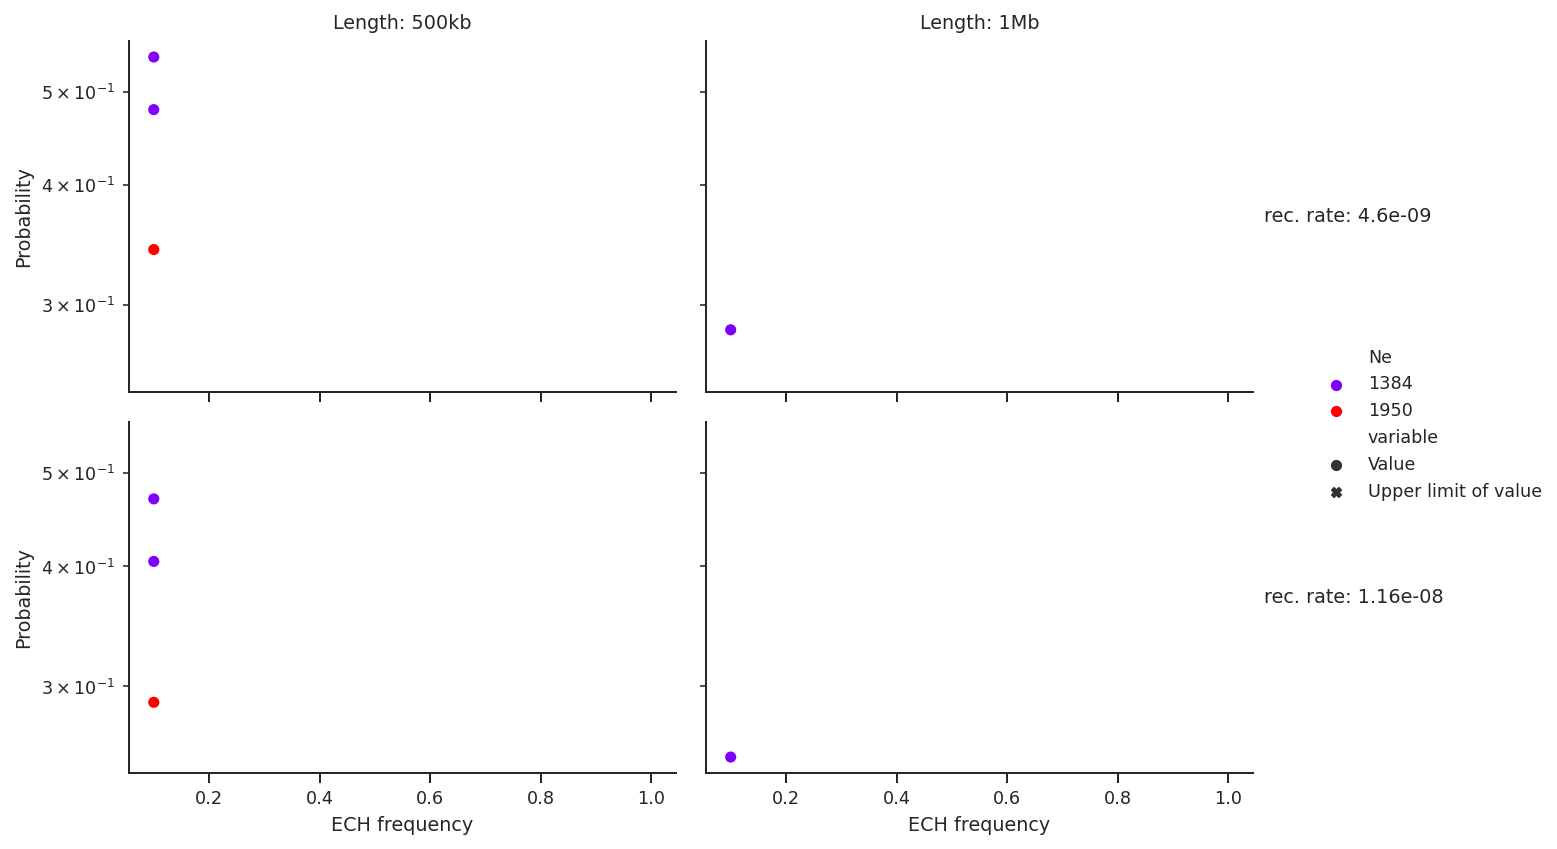

In [17]:
with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        with sns.color_palette("tab10"):
        
            g = sns.relplot(data=plot_df,
                            x='f', y='value', col='L', row='r', hue='Ne',  
                            kind='scatter', style='variable',
                              height=3, aspect=1.5,
                            palette='rainbow',
                            legend="full",                            
                            facet_kws=dict(sharex=True, sharey=True, margin_titles=True),
                            s=40
                             )
            plt.yscale('log')
            
        for ax in g.axes.flat:
            plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
            g.set_titles(row_template = 'rec. rate: {row_name}', col_template = 'Length: {col_name}')

        for ax in g.axes.flat:
            ax.set_xlabel('ECH frequency') # need to set labels manually because the names of facet function are start and end.
            ax.set_ylabel('Probability')
            plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

            
        plt.savefig(figures_dir / 'neutral_freq_sims.pdf', bbox_inches='tight')

In [10]:
df

,N,f,g,r,L,p,Value,Upper limit of value,n_samples
0,3900.0,0.1,344,4.600000e-09,500kb,0.967332,1.0,NaN,10000000
1,3900.0,0.1,344,4.600000e-09,1Mb,0.943352,1.0,NaN,10000000
2,3900.0,0.1,344,1.160000e-08,500kb,0.932743,1.0,NaN,10000000
3,3900.0,0.1,344,1.160000e-08,1Mb,0.904799,1.0,NaN,10000000
4,3900.0,0.2,344,4.600000e-09,500kb,0.222850,1.0,NaN,10000000
...,...,...,...,...,...,...,...,...,...
75,2769.0,0.9,344,1.160000e-08,1Mb,0.000000,NaN,2.157158e-09,10000000
76,2769.0,1.0,344,4.600000e-09,500kb,0.000000,NaN,6.156157e-09,10000000
77,2769.0,1.0,344,4.600000e-09,1Mb,0.000000,NaN,2.553200e-09,10000000
78,2769.0,1.0,344,1.160000e-08,500kb,0.000000,NaN,4.812020e-09,10000000


In [11]:
#Plot probability on y and target freq on x and N as color, L as color columns, r as rows...

with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        
        g = sns.FacetGrid(data=df.loc[df.prob_none_on_chr > 0],
                          col='L', row='r', hue='N',  
                          sharex=True, sharey=True, margin_titles=True,
                          height=3, aspect=1.5,            
                         )

        g.map(sns.scatterplot, 'f', 'prob_none_on_chr')
#        g.map(sns.scatterplot, 'f', 'prob_none_on_chr', marker='x')#, data=df.loc[df.prob_none_on_chr == 0])
#         g.map(sns.scatterplot, 'f', 'limit_prob_none_on_chr', marker='x', data=df.loc[df.prob_none_on_chr == 0])
#        g.set(xlim=(0, None))
        plt.yscale('log')
        g.add_legend()

        for ax in g.axes.flat:
            plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
            g.set_titles(row_template = 'Length: {row_name}', col_template = 'rec. rate: {col_name}')

        # g.set_axis_labels("Pi", "Density")

        for ax in g.axes.flat:
            ax.set_xlabel('ECH frequency') # need to set labels manually because the names of facet function are start and end.
            ax.set_ylabel('Probability')
            plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles


        plt.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'prob_none_on_chr'

In [ ]:
def freq_trajectory(N, n=1, s=0):
    yield n
    while N > n > 0:
        n = numpy.random.binomial(N, n*(1+s)/((N-n)+(n)*(1+s)), 1)[0]
        yield n

for i in range(100):
    trajectory = list(freq_trajectory(1000, n=1, s=0.05))
    plt.plot(trajectory)

Compute the probability that a single haplotype raise to some frequency in less than some number of generations without recombing.

In [47]:
N = 2 * 3000 * 0.65 * 0.71
p = 1/100000000 # prob freq reached
p * exp(-0.46e-8*5e5*344) * (1 - (1-p)**N) * 153e6 / 5e5

3.8408255297800705e-11

In [36]:
from multiprocessing import Pool
from math import exp
import itertools
import pandas as pd

# def norec_freq_reached(N, allele_count, g, r, L, n_samples=100000):
#     min_allele_count_reached = 0
#     for i in range(n_samples):
#         trajectory = list(freq_trajectory(N, n=1, s=0))
#         max_freq = max(trajectory[:g])
#         if max_freq >= allele_count:
#             nr_gens = trajectory[:g].index(max_freq) + 1
#             min_allele_count_reached += (1-(r*L))**nr_gens
#     return min_allele_count_reached / n_samples

def work(N, f, g, r, L):
    allele_count = f * N
    trajectory = list(freq_trajectory(N, n=1, s=0))
    max_freq = max(trajectory[:g])
    if max_freq >= allele_count:
        nr_gens = trajectory[:g].index(max_freq) + 1
#         return (1-(r*L))**nr_gens
        return exp(-r*L*g)
    return 0

# def norec_freq_reached(N, allele_count, g, r, L, n_samples=100000):
#     min_allele_count_reached = 0
# #     for i in range(n_samples):
# #         min_allele_count_reached += work(N, allele_count, g, r, L)
#     with Pool(int(os.environ['SLURM_CPUS_PER_TASK'])) as p:
#         min_allele_count_reached = sum(p.starmap(work, [(N, allele_count, g, r, L)]*n_samples))
#     return min_allele_count_reached / n_samples

def norec_freq_reached_by_any(N, allele_count, g, r, L, n_samples=100000):
    min_allele_count_reached = 0
#     for i in range(n_samples):
#         min_allele_count_reached += work(N, allele_count, g, r, L)
    with Pool(int(os.environ['SLURM_CPUS_PER_TASK'])) as p:
        min_allele_count_reached = sum(p.starmap(work, [(N, allele_count, g, r, L)]*n_samples))
    prob_min_allele_count_reached = min_allele_count_reached / n_samples 
    prob_min_allele_count_reached_by_any = prob_min_allele_count_reached * (1 - (1-p)**N)
    return prob_min_allele_count_reached_by_any
                                                                            
# African X/A ratio is 0.66 but is further reduce inside regions:
nonafr_x_auto_ratios = [0.65 * x for x in [1, 0.71]] # outside and inside regions

# mean per generation recombination rate in regions (new decode map):
sexavg_rec_rates_per_gen = [0.46e-8, # mean in regions
                            1.16e-8] # global for chrX


N = [2 * 3000 * x for x in nonafr_x_auto_ratios]
target_freqs = numpy.linspace(0.40, 1, 7)
g = [344]
r = sexavg_rec_rates_per_gen
L = [5e5, 1e6]

parameters = list(itertools.product(N, target_freqs, g, r, L))
n_samples = 2


# # N = 2 * 1000 * 3/4
# # #N = 2 * 1000
# # r = 1e-8 
# # g = 344
# # L = 5e5
# # n_samples = 100000000

# N = 2 * 3000 * 0.66 * 0.73
# r = 0.46e-8 
# g = 344
# L = 5e5
# #n_samples = 10000000
# n_samples = 10000

numpy.random.seed(7)

records = list()

for args in parameters:
    p = norec_freq_reached(*args, n_samples=n_samples)
    records.append((*args, p))

df = pd.DataFrame.from_records(records, columns=['N', 'f', 'g', 'r', 'L', 'p'])
df['prob_none_on_chr'] = df.p * 153e6 / df.L
df
# for f in target_freqs:
#     allele_count = f * N
#     p = norec_freq_reached(N, allele_count, g, r, L, n_samples=n_samples)
#     prob_any_allele = 1 - (1-p)**N
#     lst.append(prob_any_allele)
#     print(f, prob_any_allele)

,N,f,g,r,L,p,prob_none_on_chr
0,3900.0,0.4,344,4.600000e-09,500000.0,0.0,0.0
1,3900.0,0.4,344,4.600000e-09,1000000.0,0.0,0.0
2,3900.0,0.4,344,1.160000e-08,500000.0,0.0,0.0
3,3900.0,0.4,344,1.160000e-08,1000000.0,0.0,0.0
4,3900.0,0.5,344,4.600000e-09,500000.0,0.0,0.0
5,3900.0,0.5,344,4.600000e-09,1000000.0,0.0,0.0
6,3900.0,0.5,344,1.160000e-08,500000.0,0.0,0.0
7,3900.0,0.5,344,1.160000e-08,1000000.0,0.0,0.0
8,3900.0,0.6,344,4.600000e-09,500000.0,0.0,0.0
9,3900.0,0.6,344,4.600000e-09,1000000.0,0.0,0.0



    0.0 1.0
    0.1 0.934622419600688
    0.2 0.3075996023040558
    0.3 0.04081475270994417
    0.4 0.005097532103314206
    0.5 0.0
    0.6 0.0
    0.7 0.0
    0.8 0.0
    0.9 0.0
    1.0 0.0

Results:

    0.0 1.0
    0.1 0.8042639485907703
    0.2 0.42236999201683256
    0.3 0.17070750748121732
    0.4 0.05948008524273962
    0.5 0.018600046895680733
    0.6 0.004422087359309268
    0.7 0.0007786346523135368
    0.8 8.057652222803746e-05
    0.9 2.6859561635839135e-05
    1.0 0.0



Old results:

    0.0 1.0
    0.1 0.9505932718582353
    0.2 0.5298689815392876
    0.3 0.16527173980385934
    0.4 0.040351273355528905
    0.5 0.007807835143471498
    0.6 0.0012676017457843303
    0.7 0.00014250731399811922
    0.8 0.0
    0.9 0.0

In [9]:
max_p = exp(-r*L*g) / n_samples
max_p, 1 - (1-max_p)**N

(4.533005081656015e-09, 1.3103925264768002e-05)

In [10]:
((1-(r*L))**(g))/ n_samples

4.528876137436799e-09

In [17]:
#max_p = ((1-(r*L))**(g*0.5)) / n_samples
max_p = exp(-r*L*g) / n_samples

print('If it is zero, then it means that the prob is at most', 1 - (1-max_p)**N)

If it is zero, then it means that the prob is at most 0.013018556651099855


## Asgers computations

In [124]:
import numpy as np
#from statistics import harmonic_mean
from scipy.stats import hmean
#epoques = [(206, 100000), (311, 20000), (345, 12000), (344, 6000), (518, 4000), (689, 3000)]
epoques = [(206, 100000), (311, 20000), (345, 12000), (344, 6000), (518, 4000), (50, 3000)]
a = list()
gen_sum = 0
for g, N in epoques:
    gen_sum += g
    a.extend([N*0.66*0.73] * g)
hmean(a), gen_sum
#len(np.array(a)) / np.sum(1.0/a) 

(3420.7684303209794, 1774)

In [125]:
1774 / (3420*2)

0.25935672514619884

In [12]:
import rpy2

In [16]:
%load_ext rpy2.ipython

In [131]:
%%R -o prbv

## Consider a unlabelled sample of size n.
## We calculate the probability that j, 1<=j<=n of the samples coalesce before time t, 
## i.e. that there are 0,...,n-1 coalescent events before time t.
t <- 0.25
n <- 140
prbv <- rep(0,n)
##------------------------------------------------------
lamv <- choose(1:n,2) ## lamv[2]=1, lamv[3]=6 etc.
## j=1 (no coalescent events before time t)
prbv[1] <- exp(-lamv[n]*t)
## j=n (n-1 coalescent events before time t)
tmp <- 0
for (i in 2:n){
  tmp <- tmp + ( 1-exp(-lamv[i]*t) )*prod( lamv[-c(1,i)]/(lamv[-c(1,i)]-lamv[i]))
}
prbv[n] <- tmp
## j=2 (one coalescent events before time t)
prbv[2] <- ( lamv[n]/(lamv[n]-lamv[n-1]) )*( exp(-lamv[n-1]*t)-exp(-lamv[n]*t) )
## if n>=4:
## j from 3 to n-1
for (j in 3:(n-1)){
  tmp <- 0
  for (i in (n-j+2):n){
    lmvtmp <- lamv[(n-j+2):n]
    tmp <- tmp + ( lamv[i]/(lamv[i]-lamv[n-j+1]) )*( exp(-lamv[n-j+1]*t)-exp(-lamv[i]*t) )*
      prod( lmvtmp[-(i-(n-j+2)+1)]/(lmvtmp[-(i-(n-j+2)+1)]-lamv[i]))
  }
  prbv[j] <- tmp
}
cat(prbv,"\n")
cat(sum(prbv),"\n")


0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1.373014e-284 2.04273e-284 1.593488e-276 1.802277e-268 7.991185e-261 6.335607e-253 1.429648e-245 8.887801e-238 6.051812e-231 6.094736e-223 -7.086151e-217 7.002948e-209 -2.813614e-202 4.79298e-195 -2.29483e-188 9.854828e-182 -4.275267e-175 1.226088e-168 -9.693495e-163 -4.324995e-157 -1.890989e-150 1.817569e-144 -1.42571e-138 3.042595e-133 -2.180142e-127 2.464226e-122 -7.112644e-117 -1.576281e-112 4.600031e-107 4.065448e-102 4.244649e-97 -7.968092e-92 2.527763e-87 -6.337456e-83 1.425288e-78 -1.846715e-74 6.751637e-71 -6.664098e-67 1.035669e-62 -1.547278e-59 -3.933413e-56 1.544824e-52 3.313909e-49 2.333316e-45 1.789935e-42 8.026656e-40 -3.844264e-37 3.725631e-34 3.592999e-31 1.991718e-29 7.219134e-26 7.352205e-24 2.79597e-21 2.517078e-19 3.403789e-17 2.74738e-15 1.762818e-13 8.679282e-12 3.152729e-10 8.993118e-09 1.887945e-07 3.04436e-06 3.65781e-05 0.0003300244 0

In [132]:
sum(list(prbv)[100:])

1.0000003733601648

## Pool-Nielsen effect

In [14]:
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work
    there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

Population size reduction

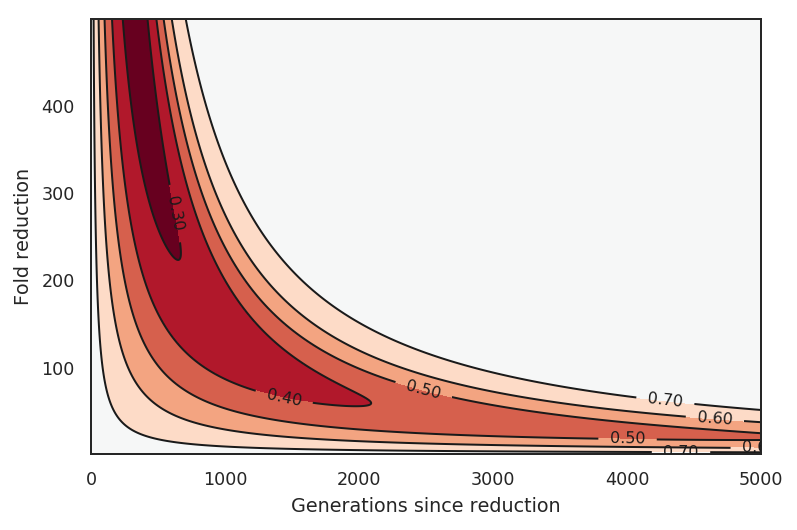

In [15]:
h = 0.75
N = 2e4
g = numpy.arange(0, 5e3)
f = 1 / numpy.arange(1, 500)

def reduction(g, f):
    return (2*N*h * (f - (f - 1) * numpy.exp(-g/(2*N*h*f)))) / \
           (2*N *   (f - (f - 1) * numpy.exp(-g/(2*N*  f)))) 

gg, ff = numpy.meshgrid(g, f, sparse=True)
z = reduction(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.1)
    plt.contourf(g, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction")
    plt.xlabel("Generations since reduction")

Population size increase:

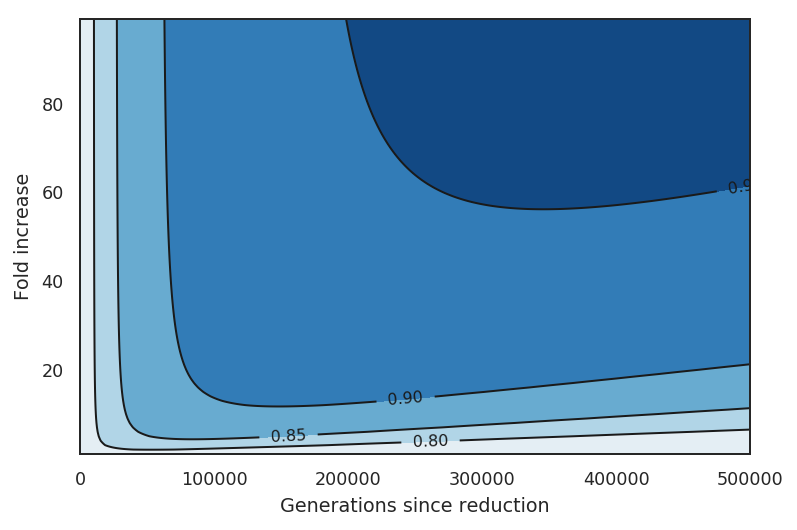

In [16]:
h = 0.75
N = 2e4
g = numpy.arange(0, 5e5, 100)
f = numpy.arange(1, 100)

def increase(g, f):
    return (2*N*h * (f - (f - 1) * numpy.exp(-g/(2*N*h*f)))) / \
           (2*N *   (f - (f - 1) * numpy.exp(-g/(2*N*  f)))) 

gg, ff = numpy.meshgrid(g, f, sparse=True)
z = reduction(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g, f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g, f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold increase")
    plt.xlabel("Generations since reduction")

Bottleneck

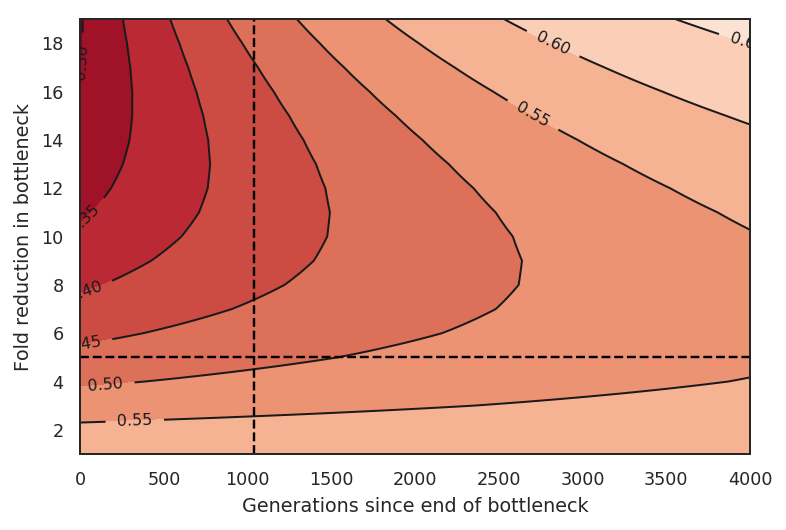

In [17]:
h = 0.6
N = 1e4
#f = 1 / np.arange(1, 500)
f = 1 / numpy.arange(1, 20)

bottle_len = 2413
bottle_end = numpy.arange(0, 4000)
g1 = bottle_end
g2 = bottle_len

def bottleneck(g1, f):
    return (2*N*h * (numpy.exp(-(f*g1+g2)/(2*N*h*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*h*f)) * (f - 1 + numpy.exp(g1/(2*N*h)))))) / \
           (2*N*1 * (numpy.exp(-(f*g1+g2)/(2*N*1*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*1*f)) * (f - 1 + numpy.exp(g1/(2*N*1))))))

gg, ff = numpy.meshgrid(g1, f, sparse=True)
z = bottleneck(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g1, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g1, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction in bottleneck")
    plt.xlabel("Generations since end of bottleneck")

    plt.axhline(5, linestyle='dashed', color='black') 
    plt.axvline(1034, linestyle='dashed', color='black') # 30000 start of bottle

#    plt.savefig(str(figures_dir / 'pool_nielsen_bottleneck.pdf'))


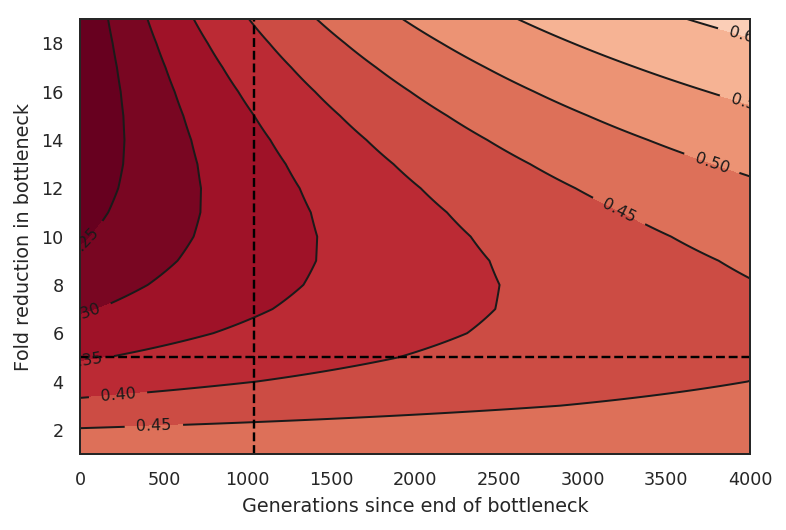

In [18]:
h = 0.5
N = 1e4
#f = 1 / np.arange(1, 500)
f = 1 / numpy.arange(1, 20)

bottle_len = 2413 # 70000
bottle_end = numpy.arange(0, 4000)
g1 = bottle_end
g2 = bottle_len

def bottleneck(g1, f):
    return (2*N*h * (numpy.exp(-(f*g1+g2)/(2*N*h*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*h*f)) * (f - 1 + numpy.exp(g1/(2*N*h)))))) / \
           (2*N*1 * (numpy.exp(-(f*g1+g2)/(2*N*1*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*1*f)) * (f - 1 + numpy.exp(g1/(2*N*1))))))

gg, ff = numpy.meshgrid(g1, f, sparse=True)
z = bottleneck(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g1, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g1, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction in bottleneck")
    plt.xlabel("Generations since end of bottleneck")
    
#    plt.savefig(str(figures_dir / 'pool_nielsen_bottleneck.pdf'))

    plt.axhline(5, linestyle='dashed', color='black') 
    plt.axvline(1034, linestyle='dashed', color='black') # 30000 start of bottle


In [10]:
import numpy as np

def exp_coal(g, N):
    return 2*N - (g * np.exp(-g/(2*N))) / (1 - np.exp(-g/(2*N)))

expectation = 0
g_prev = None
for g, N in pairs:
    if g_prev is None:
        expectation += exp_coal(g, N)
    else:
        np.exp(-g_prev/(2*N_prev)) * (prev_g + exp_coal(g, N))                  
    t_prev, N_prev = t, N


49.979166669465485